<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/main/hw01/hw01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import time

# test whether torch is available
# if not, you could apply GPU by turn on it in Edit->Notebook Settings in the control bar
torch.cuda.is_available()


False

In [99]:
# download data from Fashion-Mnist website
train_data=datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
test_data=datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

torch.Size([64, 1, 28, 28])
torch.Size([64])


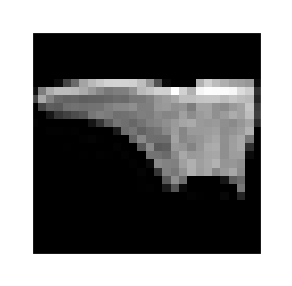

In [100]:
batch_size=64

# dataloader
train_loader=DataLoader(train_data,batch_size=batch_size)
test_loader=DataLoader(test_data,batch_size=batch_size)

# test and plot data
for X, y in test_loader:
  print(X.shape)
  print(y.shape)
  fig, ax = plt.subplots(figsize=(1,1),dpi=300)
  c = plt.pcolor(X[0,0,:,:],cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  break

In [101]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()  
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),   
            nn.ReLU(),           
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [102]:
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)       
        loss = loss_fn(pred, y) 
        train_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [103]:
epochs=5

tt=time.time()
train_loss=[]
test_loss=[]
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss = test(test_loader, model, loss_fn)
    test_loss.append(loss)

elapse=time.time()-tt
print(elapse)


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 50.6%, Avg loss: 2.167510 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.917574 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.549092 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.276126 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.109086 

79.83341217041016


In [104]:
###!mkdir drive/MyDrive/CP_data/hw01
torch.save(model.state_dict(),'drive/MyDrive/CP_data/hw01/test.pkl')

Plot the reuslts for the next week.

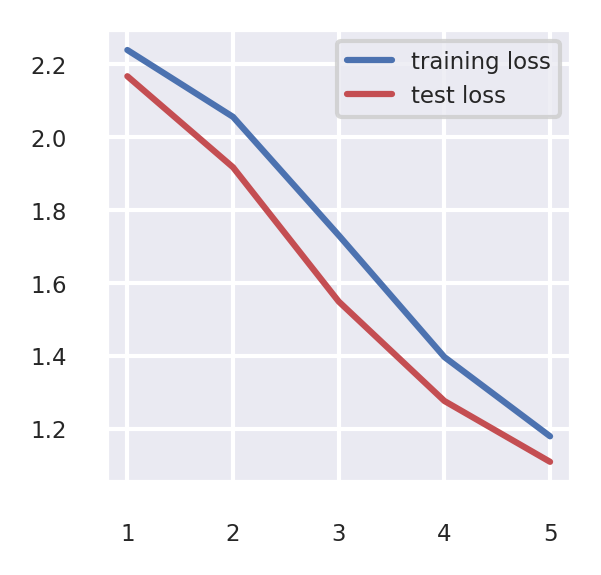

In [107]:
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
plt.legend(["training loss","test loss"])

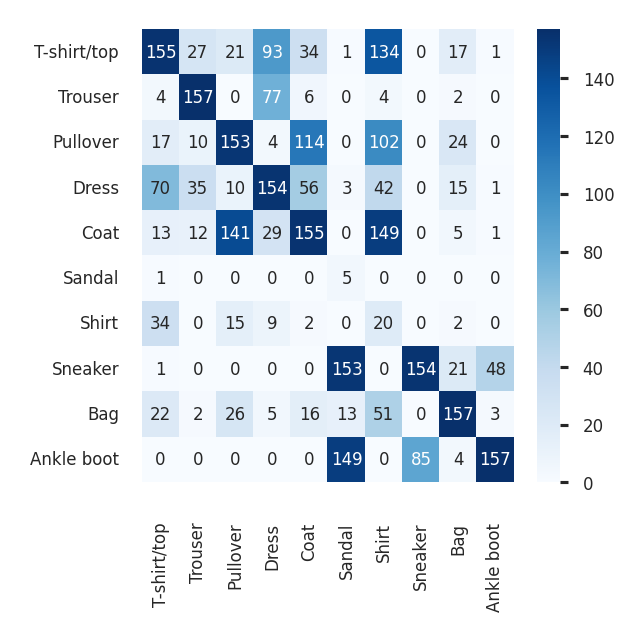

In [108]:
model2 = NeuralNetwork()
model2.load_state_dict(torch.load('drive/MyDrive/CP_data/hw01/test.pkl'))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model2.eval()

cm=np.zeros((len(classes),len(classes)))

for x,y in test_loader:
  pred = model2(x)
  cm[pred.argmax(1),y]=cm[pred.argmax(1),y]+1
  #print(f'預測值："{pred[0].argmax(0)}" / 實際值："{y[0]}"')

plt.rcParams.update({'ytick.major.size':2,'ytick.major.width':0.75})
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax=sn.heatmap(cm,xticklabels=classes,yticklabels=classes,annot=True,cmap='Blues',fmt='g',annot_kws={"fontsize":4})

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
sn.set(font_scale=0.5)
ax.tick_params(labelsize=4) 
ax.figure.axes[-1].tick_params(labelsize=4)
